### Fit 3D lines to cylinders
This project aims at fitting lines in 3D to data consisting of cylinders (produced by individual Geiger counters). Each cylinder is hence centred around an individual wire (parallel to the z-axis) on a regular grid and has a fixed radius. The cylinder height corresponds to a fixed z-coordinate error. The radius also has an error (at 10% of the radius value or at least 0.5 mm).

You have access to a file containing 10 events. The format is defined below. Each event contains data corresponding to two
lines. Each line originates from a simulated electron, each starting at the `x=0` plane from the same point, one emitted to the
left, i.e. negative x-coordinates, one to the right, with positive x-coordinates. Coordinates are given in millimetres.

The file arrives in compressed form. The column entries (and type) are
- Event number (int, starting at value 1)
- Line number (int, starting at value 1)
- Wire x-coordinate (float)
- Wire y-coordinate (float)
- Wire z-coordinate (float)
- Radius (float)
- Radius error (float)
- Wire z-coordinate error (float)

The formula describing the distance of a line to a cylinder is 

$$D = \left| (\vec{x}_{p}-\vec{x}_{0}) \times{}  \vec{u} \right| - r$$

where $\vec{u}$ is the unit direction vector of the line and $\vec{x}_{0}$ is a point on the line. The residuals between model and data also come with a weighting factor, made from the data errors, $\delta{}r$ and $\delta{}z$ according to 

$$W = \left[\sqrt{ (\delta{}z\ u_{z})^{2} + (\delta{}z\ u_{y})^{2} + (\delta{}r\ u_{z})^{2} + (\delta{}z\ u_{x})^{2} + (\delta{}r\ u_{y})^{2} + (\delta{}r\ u_{x})^{2}}\right]^{-1}$$

where $u_{x,y,z}$ represents the three components of the unit vector.

**Project**: Write an application that 
1. reads the data and 
2. fits lines to all events, 
3. counts and returns the number of successful fits, 
4. stores your results in a file with the format given below and finally 
5. plots the first event following the plot format from the example picture above.

The `runFit(infile, outfile)` function should steer the execution of the entire code with the benefit that it can be used to measure the execution time (will be done in the test, but also useful for yourself). Two data files will be supplied for the project for your own testing. One contains 10 events in the right data format and one contains truth information (as human readable file) for checking your own code. The model solution fits all 10 events correctly.

Output format for fit results:
- Event number (int, starting at 1)
- Line number (int, starting at value 1)
- intercept in y (float)
- error on intercept in y (float)
- slope in x-y plane (float)
- error on slope in x-y plane (float)
- intercept in z (float)
- error on intercept in z (float)
- slope in x-z plane (float)
- error on slope in x-z plane (float)

On storing results: it is important that every line in every event has a result, even for failed hits in order to enable the comparison for your assessment. A failed fit should therefore store a result as

```python
datastore.append((evtnr, linenr, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0))
```

with `evtnr` the event number (int) and `linenr` the line number (int).

The number of successful fits out of 20 was 20


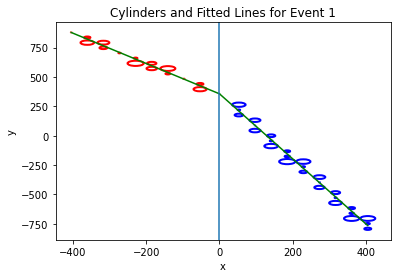

Elapsed (with compilation) = 1.259458303451538


In [2]:
'''
Fit 3D lines to cylinders
'''
import gzip
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
from numpy.linalg import norm
from numba import jit
import time

@jit(nopython=True)
def residuals(line, zsigma, rsigma, xp, r):
    '''Calculates the residuals of the best fit line to the given cylinders'''
    result = np.empty(0)
    yi = line[0]
    xy_slope = line[1]
    zi = line[2]
    xz_slope = line[3]
    x0 = np.array([0, yi, zi])
    my_u = (1/np.sqrt(1+xy_slope**2+xz_slope**2))*np.array([1, xy_slope, xz_slope])
    for i, values in enumerate(zsigma):
        _=values
        my_D = norm(np.cross(xp[i]-x0, my_u)) - r[i]
        my_W = 1/(np.sqrt((zsigma[i]*my_u[2])**2+(zsigma[i]*my_u[1])**2+(zsigma[i]*my_u[0])**2
                       +(rsigma[i]*my_u[2])**2+(rsigma[i]*my_u[1])**2+(rsigma[i]*my_u[0])**2))
        result = np.append(result, my_D*my_W)
    return result

def readData(filename):
    '''
    Read compressed data.
    '''
    return np.loadtxt(filename, delimiter=",")

def runFit(inputfilename, outputfilename):
    '''

    Parameters
    ----------
    inputfilename : string
        input data file name for fitting.
    outputfilename : string
        result storage file name.

    Returns
    -------
    counter : int
        number of successful fits; 100% would be twice the number
        of events (two lines per event).

    '''
    fulldata = readData(inputfilename)

    counter = 0

    datastore = []
    N_events = np.max(fulldata[:,0])
    for i in range(1, int(N_events)+1):
        try:
            xp1 = []
            r1 = []
            r_error1 = []
            z_error1=[]
            xp2 = []
            r2 = []
            r_error2 = []
            z_error2 = []
            index1 = np.where((fulldata[:,0]==i)&(fulldata[:,1]==1))[0]
            index2 = np.where((fulldata[:,0]==i)&(fulldata[:,1]==2))[0]
            for j in index1:
                xp1.append(np.array([fulldata[j,2], fulldata[j,3], fulldata[j,4]]))
                r1.append(fulldata[j,5])
                r_error1.append(fulldata[j,6])
                z_error1.append(fulldata[j,7])
            z_error1 = np.array(z_error1)
            r_error1 = np.array(r_error1)
            r1 = np.array(r1)
            for j in index2:
                xp2.append(np.array([fulldata[j,2], fulldata[j,3], fulldata[j,4]]))
                r2.append(fulldata[j,5])
                r_error2.append(fulldata[j,6])
                z_error2.append(fulldata[j,7])
            z_error2 = np.array(z_error2)
            r_error2 = np.array(r_error2)
            r2 = np.array(r2)
            xp1 = np.array(xp1)
            xp2 = np.array(xp2)
            #finding better initial values
            #x-y slope guesses
            l1_m = (xp1[0,1] - xp1[-1,1])/(xp1[0,0] - xp1[-1,0])
            l2_m = (xp2[0,1] - xp2[-1,1])/(xp2[0,0] - xp2[-1,0])
            #x-z slope guesses
            L1_m = (xp1[0,2] - xp1[-1,2])/(xp1[0,0] - xp1[-1,0])
            L2_m = (xp2[0,2] - xp2[-1,2])/(xp2[0,0] - xp2[-1,0])
            #y intercepts
            y_int1 = (-1)*l1_m*xp1[0,0] + xp1[0,1]
            y_int2 = (-1)*l2_m*xp2[0,0] + xp2[0,1]
            #z intercepts
            z_int1 = (-1)*L1_m*xp1[0,0] + xp1[0,2]
            z_int2 = (-1)*L2_m*xp2[0,0] + xp2[0,2]
            init1 = [y_int1, l1_m, z_int1, L1_m]
            init2 = [y_int2, l2_m, z_int2, L2_m]
            results1 = least_squares(residuals, x0=init1,
                                     bounds=(-20*np.abs(init1)-10,20*np.abs(init1)+10)
                                     ,args=(z_error1, r_error1, xp1, r1))
            results2 = least_squares(residuals, x0=init2,
                                     bounds=(-20*np.abs(init2)-10,20*np.abs(init2)+10)
                                     ,args=(z_error2, r_error2, xp2, r2))
            if not results1.success:
                datastore.append([i, 1, 0, 0, 0, 0, 0, 0, 0, 0])
            else:
                counter+=1
                vals = results1.x
                Jac = results1.jac
                # guard against singular matrix
                try:
                    cov = np.linalg.inv(Jac.T.dot(Jac))
                except:
                    cov = np.zeros((4,4))
                datastore.append([i, 1, vals[0], cov[0][0], vals[1], cov[1][1],
                                  vals[2], cov[2][2], vals[3], cov[3][3]])
            if not results2.success:
                datastore.append([i, 2, 0, 0, 0, 0, 0, 0, 0, 0])
            else:
                counter+=1
                vals = results2.x
                Jac = results2.jac
                cov = np.linalg.inv(Jac.T.dot(Jac))
                datastore.append([i, 2, vals[0], cov[0][0], vals[1], cov[1][1],
                                  vals[2], cov[2][2], vals[3], cov[3][3]])
        except:
            datastore.append([i, 2, 0, 0, 0, 0, 0, 0, 0, 0])
    with gzip.open(outputfilename, 'wt') as f:
        datastore = [", ".join('{:.6f}'.format(k) for k in row) for row in datastore]
        f.writelines('\n'.join(datastore))
    return counter

# Run the code and plot the figure
start = time.time() # starting timer

count = runFit('tendata.txt.gz', 'fits.txt.gz') # running code
print('The number of successful fits out of 20 was',count) # number of successful fits

# Plotting figure
whole_data = readData('fits.txt.gz')
data = whole_data[:2,:]
cylinders = readData('tendata.txt.gz')
fig, ax = plt.subplots()
cylinders1 = np.where((cylinders[:,0] ==1)&(cylinders[:,1] ==1))[0]
cylinders2 = np.where((cylinders[:,0] ==1)&(cylinders[:,1] ==2))[0]

for k in cylinders1:
    x = cylinders[k,2]
    y = cylinders[k,3]
    rad = cylinders[k,5]
    c = plt.Circle((x, y), rad, fill=False, lw=2, color='r')
    ax.add_patch(c)
    ax.plot()

for k in cylinders2:
    x = cylinders[k,2]
    y = cylinders[k,3]
    rad = cylinders[k,5]
    c = plt.Circle((x, y), rad, fill=False, lw=2, color ='b')
    ax.add_patch(c)
    ax.plot()
x1 = np.linspace(0, cylinders[cylinders1[-1], 2], 101)
x2 = np.linspace(0, cylinders[cylinders2[0], 2], 101)
m1 = data[0,4]
m2 = data[1,4]
y_intercept1 = data[0,2]
y_intercept2 = data[1,2]
y1 = m1*x1+y_intercept1
y2 = m2*x2+y_intercept2
plt.plot(x1, y1, 'g')
plt.plot(x2, y2, 'g')
plt.title('Cylinders and Fitted Lines for Event 1')
plt.xlabel('x')
plt.ylabel('y')
plt.axvline()
plt.show()

end = time.time() # ending timer
print("Elapsed (with compilation) = %s" % (end - start)) # how long does it take to run the code

In [ ]:
# test cell can't work since reading a file is called that you don't have. Consider it example code.
# main script
import time
start = time.process_time()
success = runFit("ringdata.txt.gz", "output.txt.gz")
stop = time.process_time()
print ("success: ", success)
print ("fit time: ", (stop-start))

# testing part
truthdata  = readData("ringtruth.txt")
outputdata = readData("output.txt.gz")

# test 1
nevents = int(outputdata[-1,0])
assert nevents == int(len(truthdata) / 2) ,'equality of data volume test failed.'

In [ ]:
# test 2: compare your fit results with the truth data and determine the fit efficiency.
# Again, can't run since you don't have the 1000 event data file for the assignment but
# may clarify what is meant by fit efficiency.
truthrow = 0
counter = 0
for evt in range(1,nevents+1):
    # select event number data
    evtdata = outputdata[outputdata[:,0]==evt]
    for i in range(2):
        # now check on values
        trueixy  = truthdata[truthrow, 0]
        trueslxy = truthdata[truthrow, 2]
        ixy  = evtdata[i, 2]
        slxy = evtdata[i, 4]
        errixy  = evtdata[i, 3]
        errslxy = evtdata[i, 5]
        # catch fit failed case
        if errixy==0.0 and errslxy==0.0:
            truthrow += 1 # next line
            continue # skip the rest below
        bool1 = trueixy <= ixy + errixy and trueixy >= ixy - errixy
        bool2 = trueslxy <= slxy + errslxy and trueslxy >= slxy - errslxy
        if bool1 and bool2:
            counter += 1
        else:
            print(bool1, bool2)
            print('True: ', trueixy, trueslxy)
            print('Fit 1: ', ixy, slxy)
            print('Error 1: ', errixy, errslxy)
        truthrow += 1 # next line
print('efficiency: ', counter/(2*nevents))
assert counter/(2*nevents)>=0.98, 'Less than 98% efficiency. Reduce marks'